# Expected persistence diagrams

Theo Lacombe

## A topological descriptor for a random process

This tutorial illustrates the notion of "Expected Persistence Diagram" introduced in a work of Chazal and Divol https://arxiv.org/pdf/1802.10457.pdf. In a nutshell, the expected persistence diagram encodes the topology of a *random* process as a *deterministic* measure. 

Recall that given an object $X$, say a point cloud embedded in the Euclidean space $\mathbb{R}^d$, one can compute its persistence diagram $\mathrm{Dgm}(X)$ which is a point cloud supported on a half-plane $\Omega \subset \mathbb{R}^2$ (see this tutorial https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistence-diagrams.ipynb for an introduction to persistence diagrams).

Now, consider that our point cloud is random. Here, we will consider that it consists of $n$ points sampled _i.i.d_ with respect to some law $\xi$, thus denoted as $\mathbb{X}_n = \{X_1 \cdots X_n\}$, with $X_i \sim \xi$. To a *random* realization of $\mathbb{X}_n$ corresponds a *random* persistence diagram. What can be said about this object? Can it be turn into a deterministic topological descriptor?

As often, the simplest way to derive from a random object a deterministic summary is to consider its average behavior. Namely, for each compact $K$ included in the half-plane $\Omega$, one can ask: _how many points of my (random) diagrams belong to $K$, on average?_. It leads to the following definition of **expected persistence diagram** of $\mathbb{X}_n$, denoted by $\mathbb{ED}(\mathbb{X}_n)$:

$$\forall K \subset \Omega, \mathbb{ED}(\mathbb{X}_n)[K] := \mathbb{E}({\mathrm{Dgm}(\mathbb{X}_n)}[K]),$$

where $\mathrm{Dgm}(\mathbb{X}_n)[K]$ is, by definition, the (random) number of points in $\mathrm{Dgm}(\mathbb{X}_n)$ that belong to $K$.

Chazal and Divol proved (under mild assumptions) that $\mathbb{ED}(\mathbb{X}_n)$ is a deterministic measure which has a density with respect to the Lebesgue measure on $\Omega$. Later, Divol and Lacombe (see https://arxiv.org/pdf/1901.03048.pdf) showed that $\mathbb{ED}(\mathbb{X}_n)$ is stable with respect to $\xi$, which states that point clouds sampled from similar random processes must have similar expected persistence diagrams.

## A numerical illustration

Theoretically computing $\mathbb{ED}(\mathbb{X}_n)$ cannot be done. In practice, one is more likely to have access to some observations $(\mathbb{X}_n^{(k)})_k \in \mathbb{R}^{d \times n \times n_\mathrm{obs}}$, $k = 1 \dots n_\mathrm{obs}$. As usual, the empirical (arithmetic) mean converges to the expectation, that is
$$\lim_{n_\mathrm{obs} \to \infty} \frac{1}{n_\mathrm{obs}} \sum_{k=1}^{n_\mathrm{obs}} \mathrm{Dgm}(\mathbb{X}_n^{(k)}) = \mathbb{ED}(\mathbb{X}_n).$$

Here, the sum of diagrams must be understood as a sum of measures. Briefly, it consists in taking the union of points in each diagram $\mathrm{Dgm}(\mathbb{X}_n^{(k)})$ (counted with multiplicity), and dividing the multiplicities (viewed as a weight) by $n_\mathrm{obs}$.

#### Experiment overview

We will showcase expected diagrams in the following context:
- Consider a point cloud $X$ with $n_\mathrm{tot}$ points, which splits in $(1-p)n_\mathrm{tot}$ points sampled on a nice shape $\mathcal{M}$ (here, a torus), and $p n_\mathrm{tot}$ outliers, where $p \in (0,1)$ is the proportion of outliers. Let us call $X_\mathrm{true}$ and $X_\mathrm{out}$ these two point clouds.
- Computing directly the (alpha complex) diagram of the whole point cloud $X$ won't reflect the topology of $\mathcal{M}$ in general, due to the presence of outliers. However, if $p$ is small enough, one can expect that by sampling $n < n_\mathrm{tot}$ points on $X$, we will avoid sampling outliers with high probability. We will thus recover a diagram close to $\mathrm{Dgm}(X_\mathrm{true})$ "most of the time", provided we sampled enough points.
- Repeating this process, and then averaging, we obtain (an estimator of) $\mathbb{ED}(\mathbb{X}_n)$.
- As the random processes $\mathbb{X}_n$ and $(\mathbb{X}_\mathrm{true})_n$ (sampling $n$ points on $X$ and on $X_\mathrm{true}$ respectively) are similar (in Wasserstein sense), so should be their expected diagrams. 

#### Imports

In [1]:
# Note: %matplotlib notebook allows for iteractive 3D plot.
%matplotlib notebook
#%matplotlib inline

In [2]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#### Sampling functions

In [3]:
def sample_circle(n):
    theta = 2 * np.pi * np.random.rand(n)
    x, y = np.cos(theta), np.sin(theta)
    return np.array([x, y]).T


def sample_torus(n, r1, r2):
    theta1 = 2 * np.pi * np.random.rand(n)
    theta2 = 2 * np.pi * np.random.rand(n)

    x = (r1 + r2 * np.cos(theta2)) * np.cos(theta1)
    y = (r1 + r2 * np.cos(theta2)) * np.sin(theta1)
    z = r2 * np.sin(theta2)

    X = np.array([x, y, z]).T

    return X

In [4]:
def sample_noise(N, ndim, scale=1., type="uniform"):
    '''
    noise sample uniforme on [-scale, scale]^2 or gaussien N(0, scale^2)
    '''
    if type=="uniform":
        X_noise = scale * (2 * np.random.rand(N, ndim) - 1)
    elif type=="gaussian":
        X_noise = scale * np.random.randn(N, ndim)
    return X_noise


def add_noise(X_noise, X):
    return np.concatenate([X, X_noise])

In [5]:
# Compute persistence diagram using the Cech filtration
def alphacomplex(X, hdim=1):
    ac = gd.AlphaComplex(points=X)
    st = ac.create_simplex_tree()
    pers = st.persistence(min_persistence=0.0001)
    h1 = st.persistence_intervals_in_dimension(hdim)
    return np.sqrt(np.array(h1))  # we must sqrt to get Cech dgm

In [6]:
def expected_dgm(X, n, k, hdim=1, replace=True):
    '''
    Subsample n points in a point cloud X, k times, and return the k computed persistence diagrams.
    '''
    N = len(X)  # total nb of points
    samples = [np.random.choice(N, n, replace=replace) for _ in range(k)]
    Xs = [X[sample] for sample in samples]
    diags = [alphacomplex(X, hdim=hdim) for X in Xs]
    return diags

#### Plot utils

In [7]:
# Discretization utils to plot expected PD in a nice way.

def discretize_dgm(diag, m=0, M=1, res=30, expo=2., filt=None, sigma=1.):
    '''
    Discretize one diagram, returns a 2D-histogram of size (res x res), the grid representing [m, M]^2.
    '''
    if diag.size:
        h2d = np.histogram2d(diag[:,0], diag[:,1], bins=res, range=[[m, M],[m, M]])[0]
        h2d = np.flip(h2d.T, axis=0)
        if filt=="gaussian":
            h2d = gaussian_filter(h2d, sigma=sigma)
        return h2d
    else:
        return np.zeros((res, res))

def tohist(diags, m=0, M=1, res=30, expo=2.,filt=None, sigma=1.):
    '''Take a list of observed diagrams 'diags' and return an histogram
    which is an estimator of E(Dgm(X_n)) for some integer n'''
    
    output = [discretize_dgm(diag, m=m, M=M, res=res, expo=expo, filt=filt, sigma=sigma)
             for diag in diags]
    return np.mean(output, axis=0)


In [8]:
def plot3d(X, X_noise):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], marker='o', color='blue')
    ax.scatter(X_noise[:,0], X_noise[:,1], X_noise[:,2], marker='x', color='red')

def plot2d(X, X_noise):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:,0], X[:,1], marker='x', color='blue')
    ax.scatter(X_noise[:,0], X_noise[:,1], marker='x', color='red')
    ax.set_aspect("equal")


def plot_object(X, X_noise):
    if X.ndim == 2:
        plot2d(X, X_noise)
    elif X.ndim == 3:
        plot3d(X, X_noise)
    else:
        print("Unknown number of dimension. Input should be a 2D or a 3D point cloud.")

In [9]:
def plot_hist(h, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.imshow(h, cmap='hot_r', interpolation='bilinear')
    L = h.shape[0]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Births", fontsize=18)
    ax.set_ylabel("Deaths", fontsize=18)
    ax.add_patch(Polygon([[L,-1], [L,L], [-1,L]], fill=True, color='lightgrey'))
    ax.set_title("Expected PD", fontsize=24)

def plot_dgm(dgm_true, dgm_tot, m, M, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    x, y = dgm_true[:,0], dgm_true[:,1]
    ax.scatter(x, y, marker='o', color='blue', label='true dgm')
    ax.scatter(dgm_tot[:,0], dgm_tot[:,1], marker='x', color='red', label='total dgm')
    ax.set_xlim(m,M)
    ax.set_ylim(m,M)
    ax.add_patch(Polygon([[m, m], [M, m], [M, M]], fill=True, color='lightgrey'))
    ax.set_aspect("equal")
    ax.set_xlabel("Births", fontsize=18)
    ax.set_ylabel("Deaths", fontsize=18)

    ax.legend()
    ax.set_title("Diagrams", fontsize=24)

### Numerical illustration

In [10]:
nb_tot = 10000
prop_noise = 0.001

nb_points = int((1 - prop_noise) * nb_tot)
nb_noise = nb_tot - nb_points

print("Number of point on the shape:", nb_points)
print("Number of points corresponding to noise:", nb_noise)
print("Proportion of noise:", prop_noise)
print("Total number of points:", nb_tot)

Number of point on the shape: 9990
Number of points corresponding to noise: 10
Proportion of noise: 0.001
Total number of points: 10000


In [11]:
# X = sample_torus(nb_points, r1 = 3, r2 = 1)
X = sample_circle(nb_points)
X_noise = sample_noise(nb_noise, 
                       ndim = X.shape[1], 
                       scale = np.std(X),
                       type="uniform")

In [12]:
X_tot = add_noise(X_noise, X)

<IPython.core.display.Javascript object>


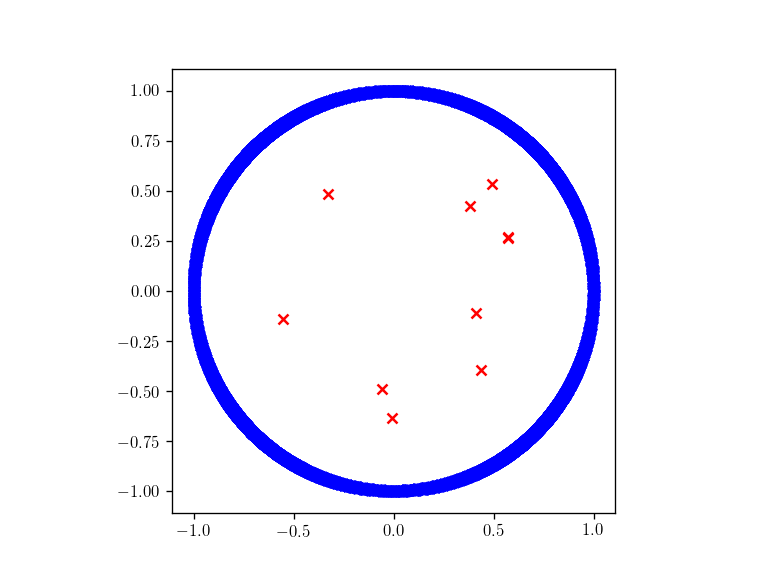

In [13]:
plot_object(X, X_noise)

In [17]:
dgm_tot = alphacomplex(X_tot)
dgm_true = alphacomplex(X)

In [18]:
nb_points_samples = 100
nb_repeat = 100

In [19]:
# Resolution parameters
m=-0.1
M=1.1

In [20]:
diags = expected_dgm(X_tot, nb_points_samples, nb_repeat)
h = tohist(diags, m=m, M=M)

<IPython.core.display.Javascript object>


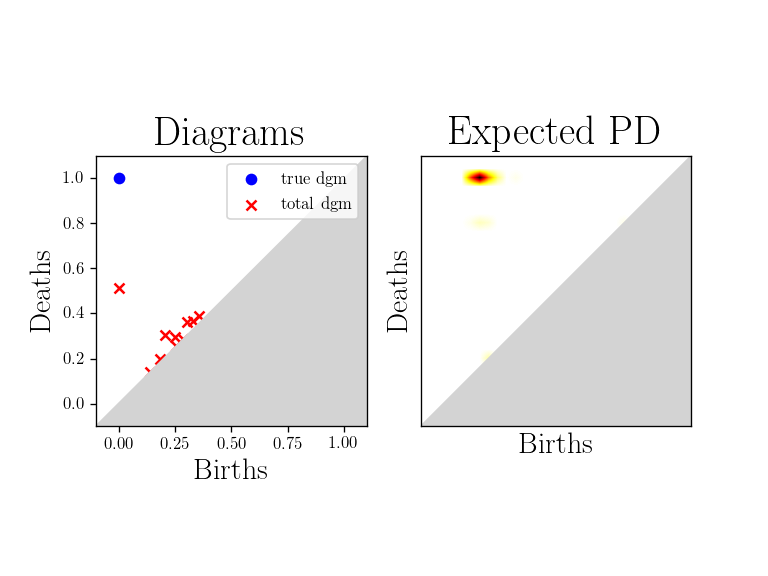

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_dgm(dgm_true, dgm_tot, m = m, M=M, ax=ax1)
plot_hist(h, ax=ax2)

As one can see, the expected persistence diagram is much more similar to the true diagram !